Problem Statement

Salah satu tantangan terbesar bagi perusahaan X adalah menentukan nilai atau value seorang calon klien agar perusahaan X dapat menentukan pendekatan atau teknik pemasaran yang cocok digunakan untuk klien tersebut.

Dengan variasi aset dan status sosial klien yang beragam, menentukan CLV pelanggan dengan tepat untuk dapat tetap kompetitif dan memastikan bahwa mereka mendapat layanan yang memuaskan sangatlah penting.


Goals

Berdasarkan permasalahan tersebut, perusahaan X tentu perlu memiliki 'tool' yang dapat memprediksi serta membantu klien mereka (dalam hal ini klien mereka) untuk dapat menentukan customer lifetime value pelanggan berdasarkan fitur-fitur tertentu dengan akurat. Adanya perbedaan pada berbagai fitur yang dimiliki klien, seperti jenis kendaraan, jumlah pendapatan, dan tingkat edukasi dapat menambah keakuratan prediksi nilai klien tersebut.

Bagi perusahaan X, prediction tool yang dapat memberikan prediksi CLV secara akurat tentu dapat meningkatkan jumlah klien. Dengan kata lain, semakin banyak klien berarti dapat meningkatkan revenue perusahaan, dalam konteks ini didapat dari premi asuransi klien.

In [ ]:
import pandas as pd  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

- Load Dataset

In [4]:
df = pd.read_csv('data_customer_lifetime_value.csv')
df.head()

,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
0,Four-Door Car,Extended,Offer1,Retired,Divorced,High School or Below,2.0,90.0,571.479602,11828.0,10083.486880
1,Four-Door Car,Basic,Offer1,Employed,Married,College,6.0,62.0,114.514440,44762.0,4943.386117
2,Two-Door Car,Basic,Offer1,Retired,Married,Master,2.0,62.0,257.248789,21514.0,11981.984810
3,Four-Door Car,Premium,Offer3,Disabled,Married,High School or Below,1.0,116.0,556.800000,17913.0,4550.856045
4,Two-Door Car,Basic,Offer3,Medical Leave,Married,High School or Below,1.0,62.0,355.820799,19030.0,2372.155492


setiap baris pada dataset ini merupakan informasi dari seorang klien dari perusahaan X. Mari kita hitung jumlah klien (jumlah baris) pada dataset ini menggunakan fungsi .shape

In [5]:
df.shape

(5669, 11)

Terdapat hasil 5669 klien pada dataset ini.

informasi apa saja mengenai di dalam dataset ini

In [6]:
display(df.describe(), df.describe(include='object'))

,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
count,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000
mean,2.979361,93.026989,431.407103,37868.188569,8029.874592
std,2.393187,34.551795,287.558038,30490.490723,6916.708246
min,1.000000,61.000000,0.423310,0.000000,1898.007675
25%,1.000000,68.000000,266.932542,0.000000,3954.344534
50%,2.000000,82.000000,379.200000,34322.000000,5800.188903
75%,4.000000,109.000000,549.986128,62464.000000,9031.214859
max,9.000000,297.000000,2759.794354,99934.000000,83325.381190


,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education
count,5669,5669,5669,5669,5669,5669
unique,6,3,4,5,3,5
top,Four-Door Car,Basic,Offer1,Employed,Married,Bachelor
freq,2858,3477,2292,3541,3305,1703


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5669 entries, 0 to 5668
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Vehicle Class            5669 non-null   object 
 1   Coverage                 5669 non-null   object 
 2   Renew Offer Type         5669 non-null   object 
 3   EmploymentStatus         5669 non-null   object 
 4   Marital Status           5669 non-null   object 
 5   Education                5669 non-null   object 
 6   Number of Policies       5669 non-null   float64
 7   Monthly Premium Auto     5669 non-null   float64
 8   Total Claim Amount       5669 non-null   float64
 9   Income                   5669 non-null   float64
 10  Customer Lifetime Value  5669 non-null   float64
dtypes: float64(5), object(6)
memory usage: 487.3+ KB


In [8]:
# Melihat apakah ada missing value pada data set ini
df.isna().sum()

Vehicle Class              0
Coverage                   0
Renew Offer Type           0
EmploymentStatus           0
Marital Status             0
Education                  0
Number of Policies         0
Monthly Premium Auto       0
Total Claim Amount         0
Income                     0
Customer Lifetime Value    0
dtype: int64

Karena tidak ada nilai NaN , saya akan mencoba kode loop untuk mengecek missing value

In [9]:
for i in df.columns:
   print(df[i].value_counts())
   print()

Vehicle Class
Four-Door Car    2858
Two-Door Car     1186
SUV              1096
Sports Car        307
Luxury SUV        115
Luxury Car        107
Name: count, dtype: int64

Coverage
Basic       3477
Extended    1704
Premium      488
Name: count, dtype: int64

Renew Offer Type
Offer1    2292
Offer2    1835
Offer3     900
Offer4     642
Name: count, dtype: int64

EmploymentStatus
Employed         3541
Unemployed       1429
Medical Leave     267
Disabled          252
Retired           180
Name: count, dtype: int64

Marital Status
Married     3305
Single      1514
Divorced     850
Name: count, dtype: int64

Education
Bachelor                1703
College                 1660
High School or Below    1620
Master                   460
Doctor                   226
Name: count, dtype: int64

Number of Policies
1.0    2008
2.0    1413
3.0     727
7.0     271
5.0     270
9.0     264
4.0     251
6.0     236
8.0     229
Name: count, dtype: int64

Monthly Premium Auto
65.0     217
71.0     203
66.0  

Seperti yang kita telah duga, ternyata pada kolom 'Income' terdapat 1429 data yang bernilai '0'. Karena jumlahnya sangat banyak, dapat kita simpulkan bahwa seluruh data pada kolom 'Income' yang bernilai '0' adalah missing values. Kita akan isi missing values ini menggunakan iterative imputer yang akan kita lakukan nanti

Cek data yang duplikat menggunakan dataframe supaya rapi

In [10]:
df_duplicate = pd.DataFrame({
    'No.':[1],
    'Jumlah Data Duplikat':df.duplicated().sum(),
    'Persentase Data Duplikat':df.duplicated().sum() / len(df) * 100,
})

df_duplicate.drop(columns='No.', inplace=True) 
#kenapa diatas sudah buat kolom No. tapi didrop? Karena kalau tidak diberikan index, maka akan error dataframenya. Untuk mengakali, dibikin dulu index, lalu didrop

df_duplicate

,Jumlah Data Duplikat,Persentase Data Duplikat
0,618,10.901394


In [11]:
df.shape[0]

5669

Ternyata, ada 618 data yang duplikat (sekitar 10.9% dari seluruh data). Karena banyak fitur kita yang berupa numerical continuous, maka kemungkinan bahwa data duplikat karena salah input sangat tinggi. Maka dari itu, untuk menghindari overfitting model, kita drop saja seluruh data duplikatnya.

In [12]:
df = df.drop_duplicates()
df.shape

(5051, 11)

Setelah menghapus data yang duplikat, mari kita perbaiki nama kolom 'EmploymentStatus' menjadi 'Employment Status' agar format penulisan menjadi konsisten

In [13]:
df = df.rename(columns={'EmploymentStatus':'Employment Status'})
df.head()

,Vehicle Class,Coverage,Renew Offer Type,Employment Status,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
0,Four-Door Car,Extended,Offer1,Retired,Divorced,High School or Below,2.0,90.0,571.479602,11828.0,10083.486880
1,Four-Door Car,Basic,Offer1,Employed,Married,College,6.0,62.0,114.514440,44762.0,4943.386117
2,Two-Door Car,Basic,Offer1,Retired,Married,Master,2.0,62.0,257.248789,21514.0,11981.984810
3,Four-Door Car,Premium,Offer3,Disabled,Married,High School or Below,1.0,116.0,556.800000,17913.0,4550.856045
4,Two-Door Car,Basic,Offer3,Medical Leave,Married,High School or Below,1.0,62.0,355.820799,19030.0,2372.155492


Cek outliers pada dataset ini

In [14]:
# Menentukan kolom numerikal
num_features = list(df.describe().columns)
del num_features[-1]
num_features

['Number of Policies', 'Monthly Premium Auto', 'Total Claim Amount', 'Income']

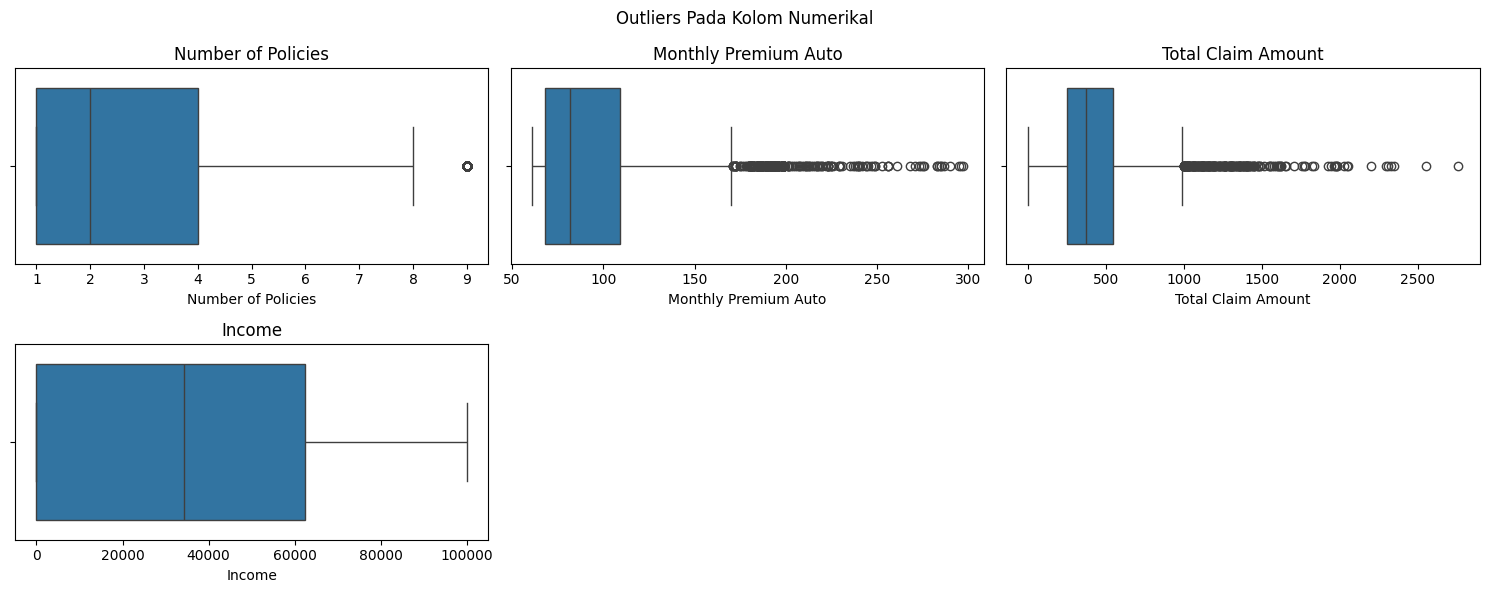

In [15]:
plotnumber = 1

plt.figure(figsize=(15,6))
plt.suptitle('Outliers Pada Kolom Numerikal')
for kolom in num_features:

    plt.subplot(2,3, plotnumber)
    sns.boxplot(data=df, x=kolom)
    plt.title(kolom)
    plt.tight_layout()

    plotnumber = plotnumber + 1

Mari kita buang data dengan Monthly Premium Auto diatas 250

In [16]:
# Jumlah data awal
df.shape[0]

5051

In [17]:
# drop outliers Monthly Premium Auto
df = df[~(df['Monthly Premium Auto'] > 250)]
df.shape[0]

5030

Ternyata ada (5051-5030) = 29 data (5051-5030)outliers pada kolom 'Monthly Premium Auto' yang terbuang. Sekarang mari kita buang data dengan Total Claim Amount diatas 2000

In [18]:
# drop outliers Total Claim Amount
df = df[~(df['Total Claim Amount'] > 2000)]
df.shape[0]

5022

Ternyata ada (5030-5022) = 8 data outliers pada kolom 'Total Claim Amount' yang terbuang. Sekarang mari kita buang data dengan Customer Lifetime Value diatas 60000

In [19]:
# drop outliers Customer Lifetime Value
df = df[~(df['Customer Lifetime Value'] > 60000)]
df.shape[0]

5017

Ternyata ada (5022-5017) = 5 data outliers pada kolom 'Customer Lifetime Value' yang terbuang

Jadi total data outliers yang kita buang ada 42 data

Sekarang, mari kita lihat hubungan antara setiap fitur dengan target (CLV)

In [20]:
cat_features = list(df.describe(include='object'))
cat_features

['Vehicle Class',
 'Coverage',
 'Renew Offer Type',
 'Employment Status',
 'Marital Status',
 'Education']

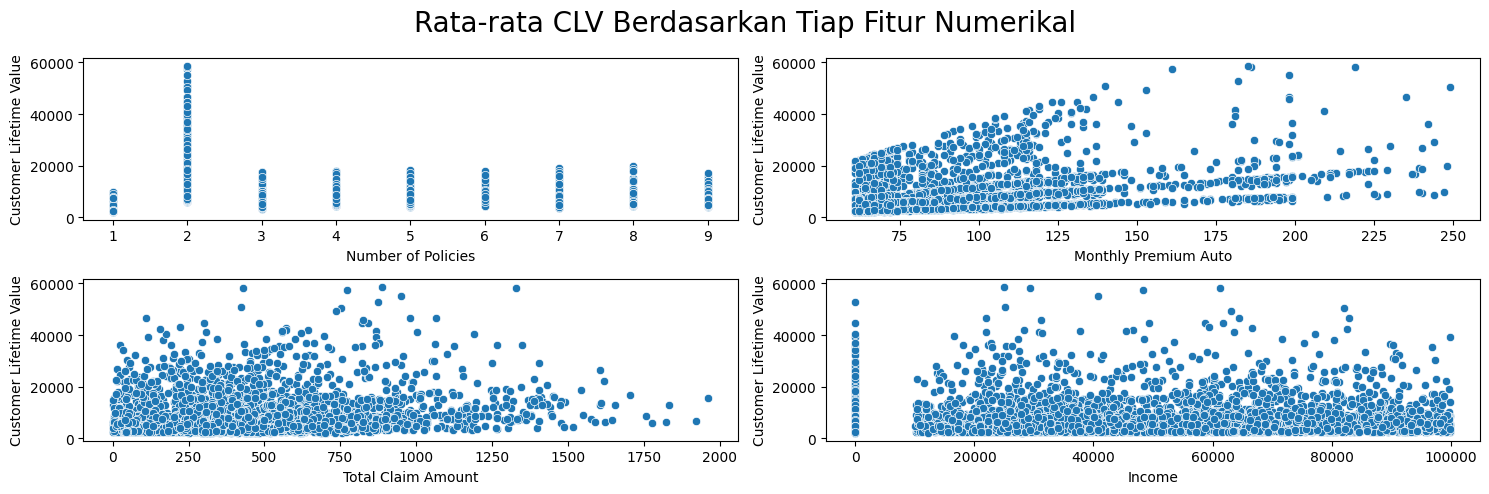

In [21]:
plot_number = 1
plt.figure(figsize=(15,5))
plt.suptitle('Rata-rata CLV Berdasarkan Tiap Fitur Numerikal', size=20)
for i in num_features:
    plt.subplot(2,2,plot_number)
    sns.scatterplot(data=df, x=df[i], y='Customer Lifetime Value')
    plt.tight_layout()
    plot_number += 1

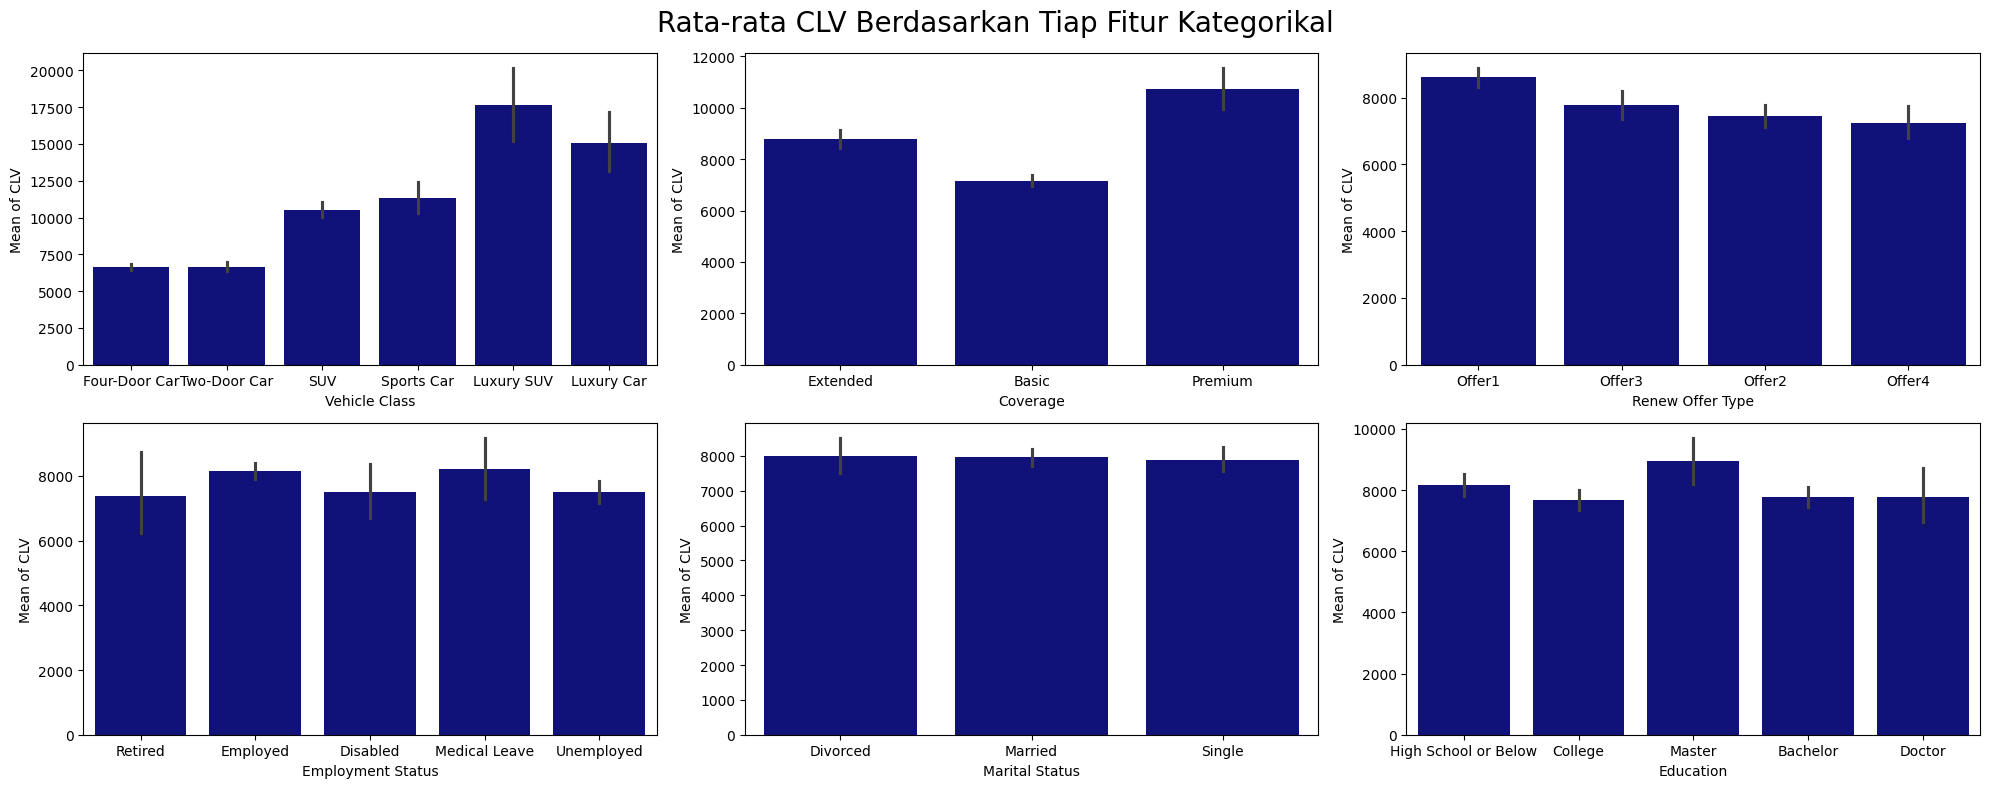

In [22]:
plot_number = 1
plt.figure(figsize=(20,8))
plt.suptitle('Rata-rata CLV Berdasarkan Tiap Fitur Kategorikal', size=20)
for i in cat_features:
    plt.subplot(2,3,plot_number)
    sns.barplot(data=df, x=df[i], y='Customer Lifetime Value', color='darkblue')
    plt.ylabel('Mean of CLV')
    plt.tight_layout()
    plot_number += 1

Dari scatterplot dan barplot diatas, dapat kita lihat bahwa fitur yang paling mungkin untuk mempengaruhi nilai CLV adalah Number of Policies, Vehicle Class, dan Coverage. Kita akan buktikan nanti menggunakan uji feature importance.

- Distribution of Categorical Feature


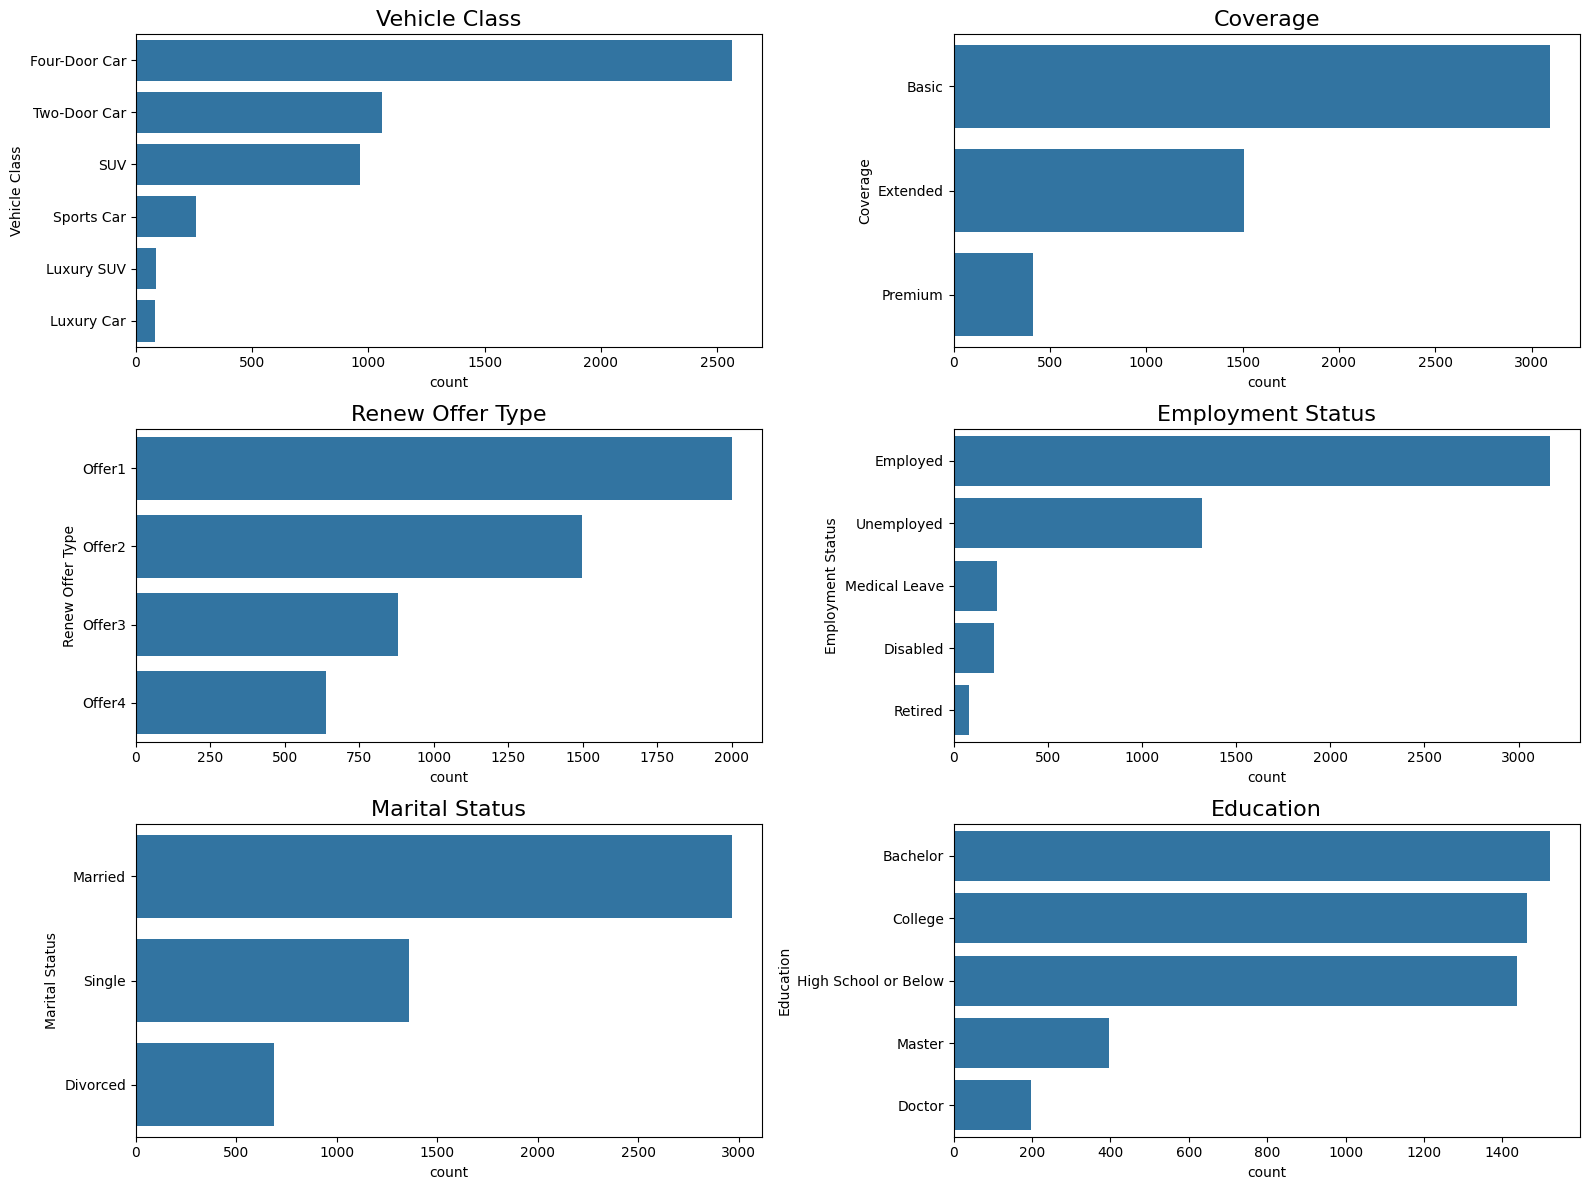

In [23]:
# Membuat variable khusus untuk feature categorical
categorical_cols = list(df.describe(include='O').columns)

plt.figure(figsize=(16,12))
num_subplot = 1

for i in categorical_cols:
    plt.subplot(3,2,num_subplot)
    sns.countplot(data=df, y=i, order=df[i].value_counts().index)
    plt.title(i, size=16)
    plt.tight_layout()
    num_subplot+=1

Bila dilihat dari feature categorical, diketahui bahwa:

-Customer yang memiliki kendaraan Four-Door Car menjadi customer terbanyak yang mengasuransikan kendaraannya.

-Mayoritas customer mengambil paket Coverage Basic sebagai paket asuransi kendaraannya.

-Apabila akan memperpanjang polis, mayoritas customer menerima Offer 1 daripada offer lainnya.

-Customer asuransi kendaraan paling banyak berstatus sudah bekerja, sudah menikah, dan berstatus pendidikan sarjana (Bachelor).

- Data Preprocessing

Sebelum kita mulai data preprocessing, mari kita tentukan X (features) dan y (target) dari dataset ini. Target dari proyek ini adalah untuk memprediksi berapa jumlah Customer Lifetime Value berdasarkan fitur-fitur yang tersedia (fitur = semua kolom selain kolom 'Customer Lifetime Value', target = kolom 'Customer Lifetime Value')

In [24]:
X = df.drop(columns='Customer Lifetime Value')
y = df['Customer Lifetime Value']

Selanjutnya, mari kita split data kita menjadi set latihan dan set ujian. Disini saya menggunakan ratio train set dengan test set sebesar 80:20 dengan random_state = 0.

Disini saya tidak menggunakan parameter 'stratify' pada data splitting karena target kita (kolom 'Customer Lifetime Value') berupa numerical continuous variable.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
display(X_train, X_test, y_train, y_test)

,Vehicle Class,Coverage,Renew Offer Type,Employment Status,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income
5524,Four-Door Car,Basic,Offer3,Employed,Married,College,5.0,74.0,250.454012,32848.0
4681,Luxury Car,Extended,Offer3,Employed,Married,Bachelor,4.0,217.0,1122.658899,39411.0
1722,Four-Door Car,Extended,Offer2,Employed,Single,Doctor,1.0,90.0,634.385937,28248.0
1469,Two-Door Car,Extended,Offer3,Unemployed,Single,High School or Below,6.0,94.0,676.800000,0.0
4205,SUV,Basic,Offer3,Employed,Divorced,Doctor,9.0,119.0,423.785148,90334.0
...,...,...,...,...,...,...,...,...,...,...
5566,Two-Door Car,Extended,Offer1,Unemployed,Single,High School or Below,2.0,89.0,538.689882,0.0
3603,Four-Door Car,Extended,Offer2,Unemployed,Married,College,8.0,80.0,488.910614,0.0
1756,Four-Door Car,Basic,Offer1,Employed,Married,Bachelor,2.0,74.0,225.518065,35300.0
2837,Four-Door Car,Basic,Offer2,Employed,Married,High School or Below,2.0,72.0,202.813730,76214.0


,Vehicle Class,Coverage,Renew Offer Type,Employment Status,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income
453,Four-Door Car,Basic,Offer4,Unemployed,Single,High School or Below,8.0,65.0,463.382118,0.0
337,Two-Door Car,Basic,Offer4,Unemployed,Married,Master,1.0,72.0,345.600000,0.0
2212,Four-Door Car,Extended,Offer1,Employed,Married,Bachelor,2.0,89.0,527.139074,75313.0
3093,Four-Door Car,Extended,Offer2,Unemployed,Divorced,High School or Below,3.0,89.0,640.800000,0.0
4020,Four-Door Car,Basic,Offer1,Unemployed,Single,College,2.0,69.0,340.780156,0.0
...,...,...,...,...,...,...,...,...,...,...
903,SUV,Extended,Offer3,Employed,Married,Master,3.0,121.0,272.788141,99654.0
3167,Four-Door Car,Basic,Offer1,Unemployed,Married,Master,2.0,67.0,321.600000,0.0
3287,Four-Door Car,Basic,Offer1,Employed,Single,Master,3.0,69.0,107.985836,74960.0
916,Four-Door Car,Extended,Offer4,Employed,Married,College,1.0,80.0,529.490007,43499.0


5524     5876.054314
4681    16936.271470
1722     3536.431774
1469     6291.589959
4205     9635.583730
            ...     
5566    24258.713830
3603     6006.963446
1756    26305.415410
2837     8676.698631
2980     3106.482540
Name: Customer Lifetime Value, Length: 4013, dtype: float64

453      4484.254754
337      2570.761765
2212    10700.495200
3093     6039.020697
4020    16938.298580
            ...     
903      9863.502214
3167    19837.305480
3287     5507.155471
916      3141.252909
875      9337.895228
Name: Customer Lifetime Value, Length: 1004, dtype: float64

Disini kita akan ganti missing values pada colom income menjadi NaN, lalu diisi dengan Iterative Imputer.

In [27]:
# Mengubah nilai '0' pada kolon 'Income' menjadi NaN
df['Income'] = df['Income'].replace([0], np.nan)

In [28]:
df['Income'].isna().sum()

np.int64(1320)

Mari kita bikin pipeline dan transformer untuk preprocess data ini.

In [29]:
df.head(3)

,Vehicle Class,Coverage,Renew Offer Type,Employment Status,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
0,Four-Door Car,Extended,Offer1,Retired,Divorced,High School or Below,2.0,90.0,571.479602,11828.0,10083.486880
1,Four-Door Car,Basic,Offer1,Employed,Married,College,6.0,62.0,114.514440,44762.0,4943.386117
2,Two-Door Car,Basic,Offer1,Retired,Married,Master,2.0,62.0,257.248789,21514.0,11981.984810


In [30]:
# Membuat ordinal mapping untuk kolom 'Coverage' dan 'Education
ordinal_mapping = [
    {'col':'Coverage', 'mapping':{'Basic':1, 'Extended':2, 'Premium':3, None:0}},
    {'col':'Education', 'mapping':{'High School or Below':1, 'College':2, 'Bachelor':3, 'Master':4, 'Doctor':5, None:0}}
]

In [31]:
# transformer 

pipe_iterative_robust = Pipeline([
    ('iterative_imputer', IterativeImputer(random_state=0)),
    ('polynomial', PolynomialFeatures(degree=1)),
    ('scaler', RobustScaler())
])

pipe_ordinal_robust = Pipeline([
    ('ordinal_encoder', OrdinalEncoder(cols=['Coverage', 'Education'], mapping=ordinal_mapping)),
    ('scaler', RobustScaler())
])

transformer = ColumnTransformer([
    ('pipe_iterative_robust', pipe_iterative_robust, ['Number of Policies', 'Monthly Premium Auto', 'Total Claim Amount', 'Income']),
    ('onehot_encoder', OneHotEncoder(drop='first'), ['Vehicle Class', 'Renew Offer Type', 'Employment Status', 'Marital Status']),
    ('ordinal_encoder', pipe_ordinal_robust, ['Coverage', 'Education']),
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipe_iterative_robust',
                                 Pipeline(steps=[('iterative_imputer',
                                                  IterativeImputer(random_state=0)),
                                                 ('polynomial',
                                                  PolynomialFeatures(degree=1)),
                                                 ('scaler', RobustScaler())]),
                                 ['Number of Policies', 'Monthly Premium Auto',
                                  'Total Claim Amount', 'Income']),
                                ('onehot_encoder', OneHotEncoder(drop='first'),
                                 ['Vehicle...
                                 Pipeline(steps=[('ordinal_encoder',
                                                  OrdinalEncoder(cols=['Coverage',
                                                                       'Education'],
                                                                 mapping=[{'col': 'Coverage',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Basic       1
Extended    2
Premium     3
None        0
dtype: int64},
                                                                          {'col': 'Education',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': High School or Below    1
College                 2
Bachelor                3
Master                  4
Doctor                  5
None                    0
dtype: int64}])),
                                                 ('scaler', RobustScaler())]),
                                 ['Coverage', 'Education'])])

Seluruh fitur numerikal akan melalui proses iterative imputer, polynomial feature, dan robust scaling.

Fitur 'Coverage' dan 'Education' memiliki tingkatan/ranking (kategorikal ordinal), maka kedua fitur ini akan melalui proses ordinal encoder dan robust scaling.

Fitur 'Vehicle Class', 'Renew Offer Type', 'Employment Status', dan 'Marital Status' akan melalui proses onehot encoder karena tidak memiliki tingkatan (kategorikal nominal).

Sisanya akan dilewati.

Mengapa saya menggunakan polynomial feature? Karena jumlah kolom yang kita punya sangat sedikit (kemungkinan model untuk underfitting akan besar), maka saya pakai polynomial feature untuk mengatasi masalah itu. Namun, cara ini belum tentu dapat meningkatkan performa model. Kita akan lihat nanti dibawah.

- Cross Validation

In [32]:
linear_regression = LinearRegression()
lasso = Lasso(alpha = 1, random_state=0)
ridge = Ridge(random_state=0)
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor(random_state=0)
rf = RandomForestRegressor(random_state=0)
adaboost = AdaBoostRegressor(random_state=0)
gboost = GradientBoostingRegressor(random_state=0)
xgboost = XGBRegressor()

list_algo = [linear_regression, lasso, ridge, knn, tree, rf, adaboost, gboost, xgboost]

Gunakan function dibawah untuk melihat daftar evaluation metric yang dapat digunakan didalam cross validation.

In [33]:
from sklearn.metrics._scorer import _SCORERS
sorted(_SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

In [34]:
eval_metric = {
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error'}

In [35]:
list_MSE = []
list_mean_MSE = []
list_std_MSE = []

list_RMSE = []
list_mean_RMSE = []
list_std_RMSE = []

list_MAE = []
list_mean_MAE = []
list_std_MAE = []

list_MAPE = []
list_mean_MAPE = []
list_std_MAPE = []

for algo in list_algo:
    pipe_model = Pipeline([
        ('transformer', transformer),
        ('algo', algo)
    ])

    # Cross validation untuk mencari model terbaik
    cv_score = cross_validate(
        estimator= pipe_model,
        X= X_train, 
        y= y_train,
        scoring= eval_metric,
        cv = 5
    )
    # MSE Score
    list_MSE.append(cv_score['test_mse'])
    list_mean_MSE.append(cv_score['test_mse'].mean())
    list_std_MSE.append(cv_score['test_mse'].std())

    # RMSE Score
    list_RMSE.append(cv_score['test_rmse'])
    list_mean_RMSE.append(cv_score['test_rmse'].mean())
    list_std_RMSE.append(cv_score['test_rmse'].std())

    # MAE Score
    list_MAE.append(cv_score['test_mae'])
    list_mean_MAE.append(cv_score['test_mae'].mean())
    list_std_MAE.append(cv_score['test_mae'].std())

    # MAPE Score
    list_MAPE.append(cv_score['test_mape'])
    list_mean_MAPE.append(cv_score['test_mape'].mean())
    list_std_MAPE.append(cv_score['test_mape'].std())

c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ~~~~~~~~~~~~~~~~~~~~^
        estimator, *args, response_method=response

In [36]:
df_cross_val = pd.DataFrame({
    'algo':list_algo,

    'mse_mean':list_mean_MSE,
    'mse_std':list_std_MSE,
    'mse_all':list_MSE,

    'rmse_mean':list_mean_RMSE,
    'rmse_std':list_std_RMSE,
    'rmse_all':list_RMSE,

    'mae_mean':list_mean_MAE,
    'mae_std':list_std_MAE,
    'mae_all':list_MAE,

    'mape_mean':list_mean_MAPE,
    'mape_std':list_std_MAPE,
    'mape_all':list_MAPE

}).sort_values('mape_mean', ascending=False)

df_cross_val.head(5)

,algo,mse_mean,mse_std,mse_all,rmse_mean,rmse_std,rmse_all,mae_mean,mae_std,mae_all,mape_mean,mape_std,mape_all
5,RandomForestRegressor(random_state=0),-1.580048e+07,2.303758e+06,"[-19490165.897119045, -15573997.759266403, -16...",-3964.405940,289.766757,"[-4414.766799856935, -3946.390472224765, -4075...",-1636.456060,139.348753,"[-1852.3831961662402, -1634.0446803596212, -16...",-0.121835,0.008417,"[-0.13688051414356606, -0.12280114563185779, -..."
4,DecisionTreeRegressor(random_state=0),-2.866165e+07,4.416965e+06,"[-36824899.812024824, -24702079.06332611, -286...",-5338.704089,399.862708,"[-6068.352314428095, -4970.118616625373, -5349...",-1948.701809,214.360221,"[-2341.4360545660024, -1785.4502910890412, -19...",-0.142181,0.014392,"[-0.17020980955628479, -0.1292327499225977, -0..."
7,GradientBoostingRegressor(random_state=0),-1.431216e+07,1.682428e+06,"[-17277344.61971827, -13657369.449224038, -145...",-3776.790622,219.115455,"[-4156.602533285841, -3695.5878354091433, -381...",-1724.231850,95.095738,"[-1856.4868537627249, -1716.3685893927413, -17...",-0.146471,0.003056,"[-0.14945300803023656, -0.14786000264097585, -..."
6,AdaBoostRegressor(random_state=0),-2.313341e+07,3.719847e+06,"[-21732241.25318272, -17898509.167875975, -226...",-4794.359306,384.089494,"[-4661.785200240646, -4230.662970253714, -4762...",-3321.146377,589.899468,"[-2841.9863647447314, -2551.990450520236, -341...",-0.421925,0.110258,"[-0.3160946135648992, -0.2803268300558657, -0...."
3,KNeighborsRegressor(),-3.990691e+07,3.613160e+06,"[-43989695.319141656, -41305875.43488131, -390...",-6310.427300,292.268016,"[-6632.4727906823455, -6426.96471399068, -6248...",-3786.637262,148.158550,"[-3831.209885716563, -3932.7692984087175, -374...",-0.560753,0.025556,"[-0.5283272436435499, -0.6055478041714192, -0...."


Dari hasil cross validation diatas, ternyata model atau algoritma ML terbaik untuk data kita adalah random forest (untuk menentukan model terbaik, saya melihat rata-rata MAPE terkecil dengan standar deviasi yang tidak besar/model stabil).

Namun, agar lebih pasti, saya akan mengambil 3 model terbaik (random forest, gradient boosting, dan decision tree) dan akan dilakukan proses grid search lalu membandingkan performa model diakhir.

- Hyperparameter Tuning


Melakukan randomized search agar proses running lebih cepat

In [37]:
hyperparam_space = {
    'modeling__n_estimators': range(10,1001,10),
    'modeling__max_depth': range(2,101,2),
    'modeling__min_samples_split': range(2,101,2),
    'modeling__min_samples_leaf': range(1,101,1),
    'modeling__max_features': ['auto', 'sqrt', 'log2', None],
    'preprocessing__pipe_iterative_robust__polynomial__degree':range(1,3)
}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', rf)
    ])

randomsearchrf1 = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

randomsearchrf1.fit(X_train, y_train)

c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
715 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
355 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\arist\Ap

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_iterative_robust',
                                                                               Pipeline(steps=[('iterative_imputer',
                                                                                                IterativeImputer(random_state=0)),
                                                                                               ('polynomial',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Number '
                                                                                'of '
                                                                                'Policies',
                                                                                'Monthly '
                                                                                'Premium '
                                                                                'Auto',
                                                                                'Total '
                                                                                'Cl...
                   param_distributions={'modeling__max_depth': range(2, 101, 2),
                                        'modeling__max_features': ['auto',
                                                                   'sqrt',
                                                                   'log2',
                                                                   None],
                                        'modeling__min_samples_leaf': range(1, 101),
                                        'modeling__min_samples_split': range(2, 101, 2),
                                        'modeling__n_estimators': range(10, 1001, 10),
                                        'preprocessing__pipe_iterative_robust__polynomial__degree': range(1, 3)},
                   random_state=0,
                   scoring='neg_mean_absolute_percentage_error')

Setelah kita lakukan tuning, mari kita cek hyperparameter terbaiknya.

In [38]:
list_resultrf1 = []

for i in randomsearchrf1.best_params_:
    result = randomsearchrf1.best_params_[i]
    list_resultrf1.append(result)

list_resultrf1.append(randomsearchrf1.best_score_)

df_randomsearch_rf_result1 = pd.DataFrame({
    'Parameter':['Polynomial Degree','n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'MAPE'],
    'Best Result':list_resultrf1
})

df_randomsearch_rf_result1

,Parameter,Best Result
0,Polynomial Degree,1.000000
1,n_estimators,640.000000
2,min_samples_split,4.000000
3,min_samples_leaf,6.000000
4,max_features,NaN
5,max_depth,60.000000
6,MAPE,-0.117525


Karena kita melakukan hyperparameter tuning menggunakan randomized search, maka hasilnya tentu bukan yang terbaik. Mari kita lakukan randomizedsearch kedua.

In [39]:
hyperparam_space = {
    'modeling__n_estimators': range(10,501,1),
    'modeling__max_depth': range(2,51,2),
    'modeling__min_samples_split': range(2,51,2),
    'modeling__min_samples_leaf': range(1,51,1),
    'modeling__max_features': ['auto', 'sqrt', 'log2', None],
    'preprocessing__pipe_iterative_robust__polynomial__degree':range(1,3)

}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', rf)
    ])

randomsearchrf2 = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

randomsearchrf2.fit(X_train, y_train)

c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
625 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
351 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\arist\Ap

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_iterative_robust',
                                                                               Pipeline(steps=[('iterative_imputer',
                                                                                                IterativeImputer(random_state=0)),
                                                                                               ('polynomial',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Number '
                                                                                'of '
                                                                                'Policies',
                                                                                'Monthly '
                                                                                'Premium '
                                                                                'Auto',
                                                                                'Total '
                                                                                'Cl...
                   param_distributions={'modeling__max_depth': range(2, 51, 2),
                                        'modeling__max_features': ['auto',
                                                                   'sqrt',
                                                                   'log2',
                                                                   None],
                                        'modeling__min_samples_leaf': range(1, 51),
                                        'modeling__min_samples_split': range(2, 51, 2),
                                        'modeling__n_estimators': range(10, 501),
                                        'preprocessing__pipe_iterative_robust__polynomial__degree': range(1, 3)},
                   random_state=0,
                   scoring='neg_mean_absolute_percentage_error')

Setelah kita lakukan tuning, mari kita cek hyperparameter terbaiknya.

In [40]:
list_resultrf2 = []

for i in randomsearchrf2.best_params_:
    result = randomsearchrf2.best_params_[i]
    list_resultrf2.append(result)

list_resultrf2.append(randomsearchrf2.best_score_)

df_randomsearch_rf_result2 = pd.DataFrame({
    'Parameter':['Polynomial Degree','n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'MAPE'],
    'Best Result':list_resultrf2
})

df_randomsearch_rf_result2

,Parameter,Best Result
0,Polynomial Degree,2.000000
1,n_estimators,221.000000
2,min_samples_split,10.000000
3,min_samples_leaf,7.000000
4,max_features,NaN
5,max_depth,50.000000
6,MAPE,-0.117501


ernyata hasilnya masih kurang memuaskan, mari kita coba sekali lagi.

In [41]:
hyperparam_space = {
    'modeling__n_estimators': range(10,251,1),
    'modeling__max_depth': range(2,26,2),
    'modeling__min_samples_split': range(2,26,2),
    'modeling__min_samples_leaf': range(1,26,1),
    'modeling__max_features': ['auto', 'sqrt', 'log2', None],
    'preprocessing__pipe_iterative_robust__polynomial__degree':range(1,3)

}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', rf)
    ])

randomsearchrf3 = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

randomsearchrf3.fit(X_train, y_train)

c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
615 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
359 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\arist\Ap

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_iterative_robust',
                                                                               Pipeline(steps=[('iterative_imputer',
                                                                                                IterativeImputer(random_state=0)),
                                                                                               ('polynomial',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Number '
                                                                                'of '
                                                                                'Policies',
                                                                                'Monthly '
                                                                                'Premium '
                                                                                'Auto',
                                                                                'Total '
                                                                                'Cl...
                   param_distributions={'modeling__max_depth': range(2, 26, 2),
                                        'modeling__max_features': ['auto',
                                                                   'sqrt',
                                                                   'log2',
                                                                   None],
                                        'modeling__min_samples_leaf': range(1, 26),
                                        'modeling__min_samples_split': range(2, 26, 2),
                                        'modeling__n_estimators': range(10, 251),
                                        'preprocessing__pipe_iterative_robust__polynomial__degree': range(1, 3)},
                   random_state=0,
                   scoring='neg_mean_absolute_percentage_error')

Setelah kita lakukan tuning, mari kita cek hyperparameter terbaiknya.

In [42]:
list_resultrf3 = []

for i in randomsearchrf3.best_params_:
    result = randomsearchrf3.best_params_[i]
    list_resultrf3.append(result)

list_resultrf3.append(randomsearchrf3.best_score_)

df_randomsearch_rf_result3 = pd.DataFrame({
    'Parameter':['Polynomial Degree','n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'MAPE'],
    'Best Result':list_resultrf3
})

df_randomsearch_rf_result3

,Parameter,Best Result
0,Polynomial Degree,1.000000
1,n_estimators,137.000000
2,min_samples_split,12.000000
3,min_samples_leaf,8.000000
4,max_features,NaN
5,max_depth,10.000000
6,MAPE,-0.117399


In [43]:
from IPython.display import display_html
# dapet dari googling ini kak librarynya

In [44]:
df_styler_rf1 = df_randomsearch_rf_result1.style.set_table_attributes("style='display:inline'").set_caption('Randomized Search Random Forest 1')
df_styler_rf2 = df_randomsearch_rf_result2.style.set_table_attributes("style='display:inline'").set_caption('Randomized Search Random Forest 2')
df_styler_rf3 = df_randomsearch_rf_result3.style.set_table_attributes("style='display:inline'").set_caption('Randomized Search Random Forest 3')


display_html(df_styler_rf1._repr_html_() + "\xa0" * 10 + df_styler_rf2._repr_html_() + "\xa0" * 10 + df_styler_rf3._repr_html_(), raw=True)

,Parameter,Best Result
0,Polynomial Degree,1.000000
1,n_estimators,640.000000
2,min_samples_split,4.000000
3,min_samples_leaf,6.000000
4,max_features,nan
5,max_depth,60.000000
6,MAPE,-0.117525
,Parameter,Best Result
0,Polynomial Degree,2.000000
1,n_estimators,221.000000


Dengan melihat nilai MAPE terkecil, maka hasil randomized search 2 dalah hyperparameter tuning terbaik dengan ketentuan parameter sebagai berikut:

In [45]:
randomsearchrf2.best_params_

{'preprocessing__pipe_iterative_robust__polynomial__degree': 2,
 'modeling__n_estimators': 221,
 'modeling__min_samples_split': 10,
 'modeling__min_samples_leaf': 7,
 'modeling__max_features': None,
 'modeling__max_depth': 50}

- Hyperparameter tuning untuk gradient boosting

In [46]:
hyperparam_space = {
    'modeling__learning_rate': np.arange(0.01,0.31,0.01),
    'modeling__max_depth': range(2,101,2),
    'modeling__min_samples_split': range(2,10,2),
    'modeling__min_samples_leaf': range(1,10,1),
    'modeling__max_features': ['auto', 'sqrt', 'log2', None],
    'modeling__n_estimators': range(10,501,1),
    'modeling__subsample': np.arange(0.5,1,0.1),
    'preprocessing__pipe_iterative_robust__polynomial__degree':range(1,3)
}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', gboost)
    ])

randomsearchgb1 = RandomizedSearchCV( 
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

randomsearchgb1.fit(X_train, y_train)

c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
650 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
247 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\arist\Ap

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_iterative_robust',
                                                                               Pipeline(steps=[('iterative_imputer',
                                                                                                IterativeImputer(random_state=0)),
                                                                                               ('polynomial',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Number '
                                                                                'of '
                                                                                'Policies',
                                                                                'Monthly '
                                                                                'Premium '
                                                                                'Auto',
                                                                                'Total '
                                                                                'Cl...
                                        'modeling__max_features': ['auto',
                                                                   'sqrt',
                                                                   'log2',
                                                                   None],
                                        'modeling__min_samples_leaf': range(1, 10),
                                        'modeling__min_samples_split': range(2, 10, 2),
                                        'modeling__n_estimators': range(10, 501),
                                        'modeling__subsample': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'preprocessing__pipe_iterative_robust__polynomial__degree': range(1, 3)},
                   random_state=0,
                   scoring='neg_mean_absolute_percentage_error')

In [47]:
list_resultgb1 = []

for i in randomsearchgb1.best_params_:
    result = randomsearchgb1.best_params_[i]
    list_resultgb1.append(result)

list_resultgb1.append(randomsearchgb1.best_score_)

df_randomsearch_gb_result1 = pd.DataFrame({
    'Parameter':['Polynomial Degree','subsample', 'n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'learning_rate' ,'MAPE'],
    'Best Result':list_resultgb1
})

df_randomsearch_gb_result1

,Parameter,Best Result
0,Polynomial Degree,1.000000
1,subsample,0.900000
2,n_estimators,456.000000
3,min_samples_split,8.000000
4,min_samples_leaf,7.000000
5,max_features,NaN
6,max_depth,48.000000
7,learning_rate,0.010000
8,MAPE,-0.122738


Mari kita lakukan random search kedua.

In [48]:
hyperparam_space = {
    'modeling__learning_rate': np.arange(0.01,0.31,0.01),
    'modeling__max_depth': range(2,54,2),
    'modeling__min_samples_split': range(2,10,2),
    'modeling__min_samples_leaf': range(1,10,1),
    'modeling__max_features': ['auto', 'sqrt', 'log2', None],
    'modeling__n_estimators': range(10,251,1),
    'modeling__subsample': np.arange(0.5,1,0.1),
    'preprocessing__pipe_iterative_robust__polynomial__degree':range(1,3)
}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', gboost)
    ])

randomsearchgb2 = RandomizedSearchCV( 
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

randomsearchgb2.fit(X_train, y_train)

c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
590 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
321 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\arist\Ap

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_iterative_robust',
                                                                               Pipeline(steps=[('iterative_imputer',
                                                                                                IterativeImputer(random_state=0)),
                                                                                               ('polynomial',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Number '
                                                                                'of '
                                                                                'Policies',
                                                                                'Monthly '
                                                                                'Premium '
                                                                                'Auto',
                                                                                'Total '
                                                                                'Cl...
                                        'modeling__max_features': ['auto',
                                                                   'sqrt',
                                                                   'log2',
                                                                   None],
                                        'modeling__min_samples_leaf': range(1, 10),
                                        'modeling__min_samples_split': range(2, 10, 2),
                                        'modeling__n_estimators': range(10, 251),
                                        'modeling__subsample': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'preprocessing__pipe_iterative_robust__polynomial__degree': range(1, 3)},
                   random_state=0,
                   scoring='neg_mean_absolute_percentage_error')

In [49]:
list_resultgb2 = []

for i in randomsearchgb2.best_params_:
    result = randomsearchgb2.best_params_[i]
    list_resultgb2.append(result)

list_resultgb2.append(randomsearchgb2.best_score_)

df_randomsearch_gb_result2 = pd.DataFrame({
    'Parameter':['Polynomial Degree','subsample', 'n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'learning_rate' ,'MAPE'],
    'Best Result':list_resultgb2
})

df_randomsearch_gb_result2

,Parameter,Best Result
0,Polynomial Degree,2.00000
1,subsample,0.80000
2,n_estimators,155.00000
3,min_samples_split,2.00000
4,min_samples_leaf,3.00000
5,max_features,NaN
6,max_depth,48.00000
7,learning_rate,0.03000
8,MAPE,-0.12379


Sekarang, random search ketiga.

In [50]:
hyperparam_space = {
    'modeling__learning_rate': np.arange(0.01,0.31,0.01),
    'modeling__max_depth': range(2,26,2),
    'modeling__min_samples_split': range(2,10,2),
    'modeling__min_samples_leaf': range(1,10,1),
    'modeling__max_features': ['auto', 'sqrt', 'log2', None],
    'modeling__n_estimators': range(10,126,1),
    'modeling__subsample': np.arange(0.5,1,0.1),
    'preprocessing__pipe_iterative_robust__polynomial__degree':range(1,3)

}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', gboost)
    ])

randomsearchgb3 = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

randomsearchgb3.fit(X_train, y_train)

c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
680 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
309 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\arist\Ap

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_iterative_robust',
                                                                               Pipeline(steps=[('iterative_imputer',
                                                                                                IterativeImputer(random_state=0)),
                                                                                               ('polynomial',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Number '
                                                                                'of '
                                                                                'Policies',
                                                                                'Monthly '
                                                                                'Premium '
                                                                                'Auto',
                                                                                'Total '
                                                                                'Cl...
                                        'modeling__max_features': ['auto',
                                                                   'sqrt',
                                                                   'log2',
                                                                   None],
                                        'modeling__min_samples_leaf': range(1, 10),
                                        'modeling__min_samples_split': range(2, 10, 2),
                                        'modeling__n_estimators': range(10, 126),
                                        'modeling__subsample': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'preprocessing__pipe_iterative_robust__polynomial__degree': range(1, 3)},
                   random_state=0,
                   scoring='neg_mean_absolute_percentage_error')

Setelah kita lakukan tuning, mari kita cek hyperparameter terbaiknya.

In [51]:
list_resultgb3 = []

for i in randomsearchgb3.best_params_:
    result = randomsearchgb3.best_params_[i]
    list_resultgb3.append(result)

list_resultgb3.append(randomsearchgb3.best_score_)

df_randomsearch_gb_result3 = pd.DataFrame({
    'Parameter':['Polynomial Degree','subsample', 'n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'learning_rate' ,'MAPE'],
    'Best Result':list_resultgb3
})

df_randomsearch_gb_result3

,Parameter,Best Result
0,Polynomial Degree,2.000000
1,subsample,0.900000
2,n_estimators,65.000000
3,min_samples_split,4.000000
4,min_samples_leaf,2.000000
5,max_features,NaN
6,max_depth,12.000000
7,learning_rate,0.070000
8,MAPE,-0.124443


In [52]:
df_styler_gb1 = df_randomsearch_gb_result1.style.set_table_attributes("style='display:inline'").set_caption('Randomized Search Gradient Boost 1')
df_styler_gb2 = df_randomsearch_gb_result2.style.set_table_attributes("style='display:inline'").set_caption('Randomized Search Gradient Boost 2')
df_styler_gb3 = df_randomsearch_gb_result3.style.set_table_attributes("style='display:inline'").set_caption('Randomized Search Gradient Boost 3')


display_html(df_styler_gb1._repr_html_() + "\xa0" * 10 + df_styler_gb2._repr_html_() + "\xa0" * 10 + df_styler_gb3._repr_html_(), raw=True)

,Parameter,Best Result
0,Polynomial Degree,1.000000
1,subsample,0.900000
2,n_estimators,456.000000
3,min_samples_split,8.000000
4,min_samples_leaf,7.000000
5,max_features,nan
6,max_depth,48.000000
7,learning_rate,0.010000
8,MAPE,-0.122738
,Parameter,Best Result


Dengan melihat nilai MAPE terkecil, maka kita akan pilih hyperparameter dari randomized search 1 dengan ketentuan parameter sebagai berikut:

In [53]:
randomsearchgb1.best_params_

{'preprocessing__pipe_iterative_robust__polynomial__degree': 1,
 'modeling__subsample': np.float64(0.8999999999999999),
 'modeling__n_estimators': 456,
 'modeling__min_samples_split': 8,
 'modeling__min_samples_leaf': 7,
 'modeling__max_features': None,
 'modeling__max_depth': 48,
 'modeling__learning_rate': np.float64(0.01)}

- Hyperparameter tuning untuk decision tree

In [54]:
hyperparam_space = {
    'modeling__max_depth': range(2,101,2),
    'modeling__min_samples_split': range(2,10,2),
    'modeling__min_samples_leaf': range(1,10,1),
    'modeling__max_features': ['auto', 'sqrt', 'log2', None],
    'modeling__ccp_alpha': [0, 0.001, 0.01],
    'preprocessing__pipe_iterative_robust__polynomial__degree':range(1,3)

}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', tree)
    ])

randomsearchtree1 = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

randomsearchtree1.fit(X_train, y_train)

c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
595 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
337 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\arist\Ap

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_iterative_robust',
                                                                               Pipeline(steps=[('iterative_imputer',
                                                                                                IterativeImputer(random_state=0)),
                                                                                               ('polynomial',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Number '
                                                                                'of '
                                                                                'Policies',
                                                                                'Monthly '
                                                                                'Premium '
                                                                                'Auto',
                                                                                'Total '
                                                                                'Cl...
                   param_distributions={'modeling__ccp_alpha': [0, 0.001, 0.01],
                                        'modeling__max_depth': range(2, 101, 2),
                                        'modeling__max_features': ['auto',
                                                                   'sqrt',
                                                                   'log2',
                                                                   None],
                                        'modeling__min_samples_leaf': range(1, 10),
                                        'modeling__min_samples_split': range(2, 10, 2),
                                        'preprocessing__pipe_iterative_robust__polynomial__degree': range(1, 3)},
                   random_state=0,
                   scoring='neg_mean_absolute_percentage_error')

In [55]:
list_resulttree1 = []

for i in randomsearchtree1.best_params_:
    result = randomsearchtree1.best_params_[i]
    list_resulttree1.append(result)

list_resulttree1.append(randomsearchtree1.best_score_)

df_randomsearch_tree_result1 = pd.DataFrame({
    'Parameter':['Polynomial Degree','min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'ccp_alpha', 'MAPE'],
    'Best Result':list_resulttree1
})

df_randomsearch_tree_result1

,Parameter,Best Result
0,Polynomial Degree,1.000000
1,min_samples_split,6.000000
2,min_samples_leaf,9.000000
3,max_features,NaN
4,max_depth,94.000000
5,ccp_alpha,0.000000
6,MAPE,-0.123775


Mari kita lakukan random search kedua.

In [56]:
hyperparam_space = {
    'modeling__max_depth': range(2,56,2),
    'modeling__min_samples_split': range(2,10,2),
    'modeling__min_samples_leaf': range(1,10,1),
    'modeling__max_features': ['auto', 'sqrt', 'log2', None],
    'modeling__ccp_alpha': [0, 0.001, 0.01],
    'preprocessing__pipe_iterative_robust__polynomial__degree':range(1,3)

}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', tree)
    ])

randomsearchtree2 = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

randomsearchtree2.fit(X_train, y_train)

c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
705 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
316 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\arist\Ap

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_iterative_robust',
                                                                               Pipeline(steps=[('iterative_imputer',
                                                                                                IterativeImputer(random_state=0)),
                                                                                               ('polynomial',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Number '
                                                                                'of '
                                                                                'Policies',
                                                                                'Monthly '
                                                                                'Premium '
                                                                                'Auto',
                                                                                'Total '
                                                                                'Cl...
                   param_distributions={'modeling__ccp_alpha': [0, 0.001, 0.01],
                                        'modeling__max_depth': range(2, 56, 2),
                                        'modeling__max_features': ['auto',
                                                                   'sqrt',
                                                                   'log2',
                                                                   None],
                                        'modeling__min_samples_leaf': range(1, 10),
                                        'modeling__min_samples_split': range(2, 10, 2),
                                        'preprocessing__pipe_iterative_robust__polynomial__degree': range(1, 3)},
                   random_state=0,
                   scoring='neg_mean_absolute_percentage_error')

In [57]:
list_resulttree2 = []

for i in randomsearchtree1.best_params_:
    result = randomsearchtree1.best_params_[i]
    list_resulttree2.append(result)

list_resulttree2.append(randomsearchtree1.best_score_)

df_randomsearch_tree_result2 = pd.DataFrame({
    'Parameter':['Polynomial Degree','min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'ccp_alpha', 'MAPE'],
    'Best Result':list_resulttree2
})

df_randomsearch_tree_result2

,Parameter,Best Result
0,Polynomial Degree,1.000000
1,min_samples_split,6.000000
2,min_samples_leaf,9.000000
3,max_features,NaN
4,max_depth,94.000000
5,ccp_alpha,0.000000
6,MAPE,-0.123775


Mari kita lakukan random search ketiga.

In [58]:
hyperparam_space = {
    'modeling__max_depth': range(2,26,2),
    'modeling__min_samples_split': range(2,10,2),
    'modeling__min_samples_leaf': range(1,10,1),
    'modeling__max_features': ['auto', 'sqrt', 'log2', None],
    'modeling__ccp_alpha': [0, 0.001, 0.01],
    'preprocessing__pipe_iterative_robust__polynomial__degree':range(1,3)

}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', tree)
    ])

randomsearchtree3 = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

randomsearchtree3.fit(X_train, y_train)

c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
570 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
316 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\arist\Ap

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_iterative_robust',
                                                                               Pipeline(steps=[('iterative_imputer',
                                                                                                IterativeImputer(random_state=0)),
                                                                                               ('polynomial',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Number '
                                                                                'of '
                                                                                'Policies',
                                                                                'Monthly '
                                                                                'Premium '
                                                                                'Auto',
                                                                                'Total '
                                                                                'Cl...
                   param_distributions={'modeling__ccp_alpha': [0, 0.001, 0.01],
                                        'modeling__max_depth': range(2, 26, 2),
                                        'modeling__max_features': ['auto',
                                                                   'sqrt',
                                                                   'log2',
                                                                   None],
                                        'modeling__min_samples_leaf': range(1, 10),
                                        'modeling__min_samples_split': range(2, 10, 2),
                                        'preprocessing__pipe_iterative_robust__polynomial__degree': range(1, 3)},
                   random_state=0,
                   scoring='neg_mean_absolute_percentage_error')

In [59]:
list_resulttree3 = []

for i in randomsearchtree3.best_params_:
    result = randomsearchtree3.best_params_[i]
    list_resulttree3.append(result)

list_resulttree3.append(randomsearchtree3.best_score_)

df_randomsearch_tree_result3 = pd.DataFrame({
    'Parameter':['Polynomial Degree', 'min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'ccp_alpha', 'MAPE'],
    'Best Result':list_resulttree3
})

df_randomsearch_tree_result3

,Parameter,Best Result
0,Polynomial Degree,1.000000
1,min_samples_split,8.000000
2,min_samples_leaf,6.000000
3,max_features,NaN
4,max_depth,8.000000
5,ccp_alpha,0.010000
6,MAPE,-0.121631


In [60]:
df_styler_tree1 = df_randomsearch_tree_result1.style.set_table_attributes("style='display:inline'").set_caption('Randomized Search Decision Tree 1')
df_styler_tree2 = df_randomsearch_tree_result2.style.set_table_attributes("style='display:inline'").set_caption('Randomized Search Decision Tree 2')
df_styler_tree3 = df_randomsearch_tree_result3.style.set_table_attributes("style='display:inline'").set_caption('Randomized Search Decision Tree 3')


display_html(df_styler_tree1._repr_html_() + "\xa0" * 10 + df_styler_tree2._repr_html_() + "\xa0" * 10 + df_styler_tree3._repr_html_(), raw=True)

,Parameter,Best Result
0,Polynomial Degree,1.000000
1,min_samples_split,6.000000
2,min_samples_leaf,9.000000
3,max_features,nan
4,max_depth,94.000000
5,ccp_alpha,0.000000
6,MAPE,-0.123775
,Parameter,Best Result
0,Polynomial Degree,1.000000
1,min_samples_split,6.000000


Dengan melihat nilai MAPE terkecil, maka kita akan pilih hyperparameter dari randomized search 3 dengan ketentuan parameter sebagai berikut:

In [61]:
randomsearchtree3.best_params_

{'preprocessing__pipe_iterative_robust__polynomial__degree': 1,
 'modeling__min_samples_split': 8,
 'modeling__min_samples_leaf': 6,
 'modeling__max_features': None,
 'modeling__max_depth': 8,
 'modeling__ccp_alpha': 0.01}

Ringkasan seluruh hasil randomized search

In [62]:
display_html(df_styler_rf1._repr_html_() + "\xa0" * 10 + df_styler_rf2._repr_html_() + "\xa0" * 10 + df_styler_rf3._repr_html_(), raw=True)
display_html(df_styler_gb1._repr_html_() + "\xa0" * 10 + df_styler_gb2._repr_html_() + "\xa0" * 10 + df_styler_gb3._repr_html_(), raw=True)
display_html(df_styler_tree1._repr_html_() + "\xa0" * 10 + df_styler_tree2._repr_html_() + "\xa0" * 10 + df_styler_tree3._repr_html_(), raw=True)

,Parameter,Best Result
0,Polynomial Degree,1.000000
1,n_estimators,640.000000
2,min_samples_split,4.000000
3,min_samples_leaf,6.000000
4,max_features,nan
5,max_depth,60.000000
6,MAPE,-0.117525
,Parameter,Best Result
0,Polynomial Degree,2.000000
1,n_estimators,221.000000


,Parameter,Best Result
0,Polynomial Degree,1.000000
1,subsample,0.900000
2,n_estimators,456.000000
3,min_samples_split,8.000000
4,min_samples_leaf,7.000000
5,max_features,nan
6,max_depth,48.000000
7,learning_rate,0.010000
8,MAPE,-0.122738
,Parameter,Best Result


,Parameter,Best Result
0,Polynomial Degree,1.000000
1,min_samples_split,6.000000
2,min_samples_leaf,9.000000
3,max_features,nan
4,max_depth,94.000000
5,ccp_alpha,0.000000
6,MAPE,-0.123775
,Parameter,Best Result
0,Polynomial Degree,1.000000
1,min_samples_split,6.000000


Dari hasil cross validation, hyperparameter tuning, dan randomized search, model terbaik adalah random forest dengan hyperparameter sebagai berikut:

In [63]:
# Menampilkan parameter random forest terbaik
randomsearchrf2.best_params_

{'preprocessing__pipe_iterative_robust__polynomial__degree': 2,
 'modeling__n_estimators': 221,
 'modeling__min_samples_split': 10,
 'modeling__min_samples_leaf': 7,
 'modeling__max_features': None,
 'modeling__max_depth': 50}

Ternyata, Polynomial Degree terbaik adalah 1, jadi kita ternyata tidak perlu melakukan polynomial feature karena tidak meningkatkan performa model.

- Modeling


Setelah melakukan proses cross validation, randomized search, dan hyperparameter tuning, model terbaik untuk memprediksi nilai CLV klien pada dataset ini adalah Random Forest Regressor.

Random Forest Regressor adalah sebuah model atau algoritma machine learning untuk memprediksi suatu nilai numerikal. Model ini bekerja dengan membuat beberapa pohon keputusan (atau model decision tree) dan menggabungkan hasil dari setiap pohon untuk membuat prediksi akhir. Setiap pohon dibuat secara acak dari dataset. Setiap pohon membuat prediksi sendiri dan hasil dari semua pohon digabungkan menjadi prediksi akhir. Gabungan ini biasanya dilakukan dengan mengambil rata-rata dari hasil prediksi dari setiap pohon.

Random Forest Regressor memiliki beberapa keuntungan, seperti tingkat stabilitas model yang tinggi dan kemampuan untuk menangani kasus dimana ada fitur yang memiliki pengaruh besar pada target dan juga meminimalisir overfitting. Namun, metode ini membutuhkan waktu proses yang lebih lama dibandingkan dengan metode lainnya dan juga membutuhkan lebih banyak memori karena banyaknya pohon yang dibangun. Disini saya mengatasi masalah ini dengan membatasi jumlah pohon yang dibuat didalam parameter n_estimators.

Predict ke test set sebelum tuning (menggunakan benchmark model).

In [64]:
model = RandomForestRegressor(random_state=0)

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', model)
    ])

pipe_model.fit(X_train, y_train)

y_pred_before = pipe_model.predict(X_test)


MAPE_before = mean_absolute_percentage_error(y_test, y_pred_before)
MAE_before = mean_absolute_error(y_test, y_pred_before)
MSE_before = mean_squared_error(y_test, y_pred_before)
RMSE_before = MSE_before ** 0.5

Predict ke test set setelah tuning (menggunakan model dengan hyperparameter terbaik).

In [65]:
# ini hanya untuk formatting jumlah angka dibelakang koma
pd.options.display.float_format = "{:.10f}".format

Mari kita buat sebuah tabel yang berisi perbandingan performa model sebelum dan sesudah proses tuning.

In [66]:
model = randomsearchrf2.best_estimator_

model.fit(X_train, y_train)

y_pred_after = model.predict(X_test)


MAPE_after = mean_absolute_percentage_error(y_test, y_pred_after)
MAE_after = mean_absolute_error(y_test, y_pred_after)
MSE_after = mean_squared_error(y_test, y_pred_after)
RMSE_after = MSE_after ** 0.5

In [67]:
df_compare = pd.DataFrame({
    'Kondisi':['Sebelum tuning', 'Setelah tuning'],
    'MAPE': [MAPE_before, MAPE_after],
    'MAE': [MAE_before, MAE_after],
    'MSE': [MSE_before, MSE_after],
    'RMSE': [RMSE_before, RMSE_after]
})

df_compare

,Kondisi,MAPE,MAE,MSE,RMSE
0,Sebelum tuning,0.1340561175,1755.3251396067,15981234.7188811284,3997.6536516913
1,Setelah tuning,0.1302280216,1728.7589870782,15166792.8268820383,3894.4566792920


model yg mengalami peningkata performa (MAPE,MAE,MSE,RMSE)

Sebelum x sesedah proises tuning :

-Mape = 13.27% x 12.96%

-Mae = 1745.54 x 1722.37

-Mse = 15661807.77 x 15107803.11

-Rmse = 3957.50 x 3886.88

Mari kita buat scatterplot untuk melihat perbandingan antara CLV asli dengan CLV hasil prediksi model.

''

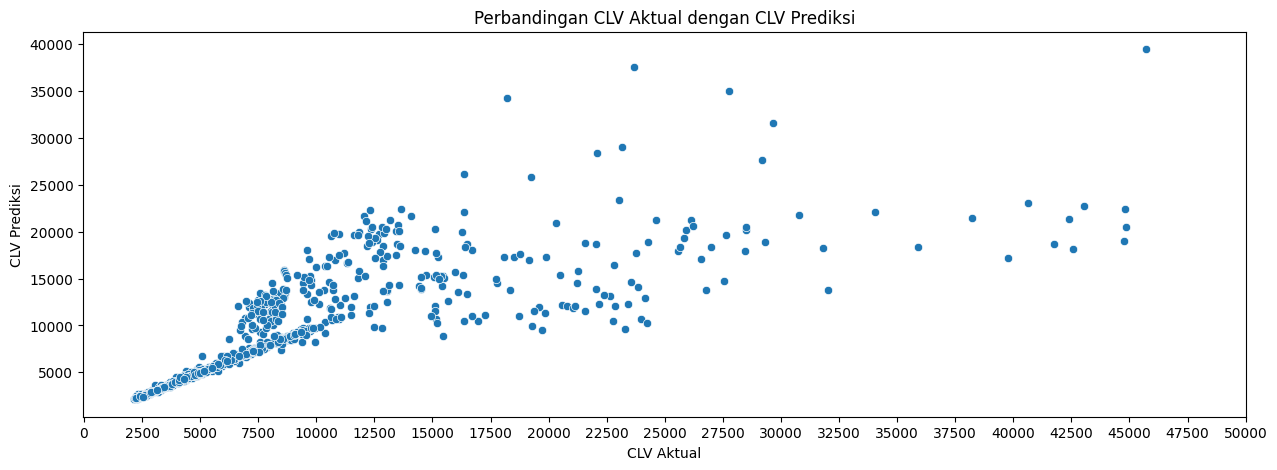

In [68]:
plt.figure(figsize=(15,5))
plot = sns.scatterplot(x=y_test, y=y_pred_after).set(title='Perbandingan CLV Aktual dengan CLV Prediksi', 
                                               xlabel='CLV Aktual', 
                                               ylabel='CLV Prediksi')
plt.xticks(ticks=range(0,50001,2500))
;

Adanya nilai-nilai error yang besar membuat perbedaan yang cukup signifikan antara nilai RMSE dan MAE. Hal ini dapat tergambarkan pula pada scatterplot di atas, di mana terdapat CLV aktual yang rendah tapi diprediksi jauh lebih tinggi (overestimation), dan juga sebaliknya (underestimation).

Dari scatterplot diatas dapat kita amati bahwa pada nilai CLV yang lebih kecil, model ini cenderung lebih akurat dalam memprediksi CLV klien. Namun, semakin besar nilai CLV aktual, maka hasil prediksi model menjadi semakin tidak akurat. Ini menjadi salah satu limitasi

Mari kita lihat fitur-fitur apa saja yang paling penting untuk menentukan nilai CLV seorang klien.

In [69]:
# Mencari nama kolom untuk fitur numerikal
column_numerical = list(randomsearchrf2.best_estimator_['preprocessing'].transformers_[0][1][1].get_feature_names_out())
column_numerical[0] = 'Constant'
column_numerical[1] = 'Number of Policies'
column_numerical[2] = 'Monthly Premium Auto'
column_numerical[3] = 'Total Claim Amount'
column_numerical[4] = 'Income'
column_numerical

['Constant',
 'Number of Policies',
 'Monthly Premium Auto',
 'Total Claim Amount',
 'Income',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x2^2',
 'x2 x3',
 'x3^2']

In [70]:
# Mencari nama kolom untuk pipeline ordinal_robust
column_ordinal_robust = list(transformer.transformers_[2][1][0].get_feature_names_out())
column_ordinal_robust[0] = 'Coverage'
column_ordinal_robust[1] = 'Education'
column_ordinal_robust


['Coverage', 'Education']

In [71]:
# Mencari nama kolom untuk onehot encoder
column_onehot = list(transformer.transformers_[1][1].get_feature_names_out())
column_onehot

['Vehicle Class_Luxury Car',
 'Vehicle Class_Luxury SUV',
 'Vehicle Class_SUV',
 'Vehicle Class_Sports Car',
 'Vehicle Class_Two-Door Car',
 'Renew Offer Type_Offer2',
 'Renew Offer Type_Offer3',
 'Renew Offer Type_Offer4',
 'Employment Status_Employed',
 'Employment Status_Medical Leave',
 'Employment Status_Retired',
 'Employment Status_Unemployed',
 'Marital Status_Married',
 'Marital Status_Single']

In [72]:
# Menggabungkan nama kolom yang sudah didapat
col_all = column_numerical + column_ordinal_robust + column_onehot
col_all

['Constant',
 'Number of Policies',
 'Monthly Premium Auto',
 'Total Claim Amount',
 'Income',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x2^2',
 'x2 x3',
 'x3^2',
 'Coverage',
 'Education',
 'Vehicle Class_Luxury Car',
 'Vehicle Class_Luxury SUV',
 'Vehicle Class_SUV',
 'Vehicle Class_Sports Car',
 'Vehicle Class_Two-Door Car',
 'Renew Offer Type_Offer2',
 'Renew Offer Type_Offer3',
 'Renew Offer Type_Offer4',
 'Employment Status_Employed',
 'Employment Status_Medical Leave',
 'Employment Status_Retired',
 'Employment Status_Unemployed',
 'Marital Status_Married',
 'Marital Status_Single']

In [73]:
# Membuat dataframe yang berisi fitur beserta tingkat kepentingannya (feature importance)
feature_imp_df = pd.DataFrame(randomsearchrf2.best_estimator_['modeling'].feature_importances_, col_all)
feature_imp_df.rename(columns={0:'Feature Importance'}, inplace=True)
feature_imp_df

,Feature Importance
Constant,0.0000000000
Number of Policies,0.3097073944
Monthly Premium Auto,0.0967791934
Total Claim Amount,0.0083760876
Income,0.0047324355
x0^2,0.2949657569
x0 x1,0.0694730717
x0 x2,0.0087079237
x0 x3,0.0048580074
x1^2,0.1046170304


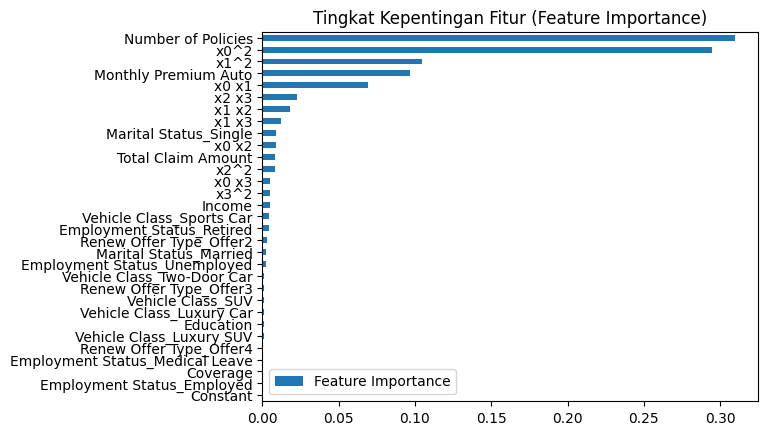

In [74]:
# Menampilkan tingkat kepentingan tiap fitur kedalam barplot
feature_imp = feature_imp_df.sort_values(by='Feature Importance')
feature_imp.plot(kind='barh', title='Tingkat Kepentingan Fitur (Feature Importance)');

Ternyata, fitur yang paling penting untuk menentukan nilai CLV seorang klien adalah Number of Policies (jumlah polis asuransi yang dimiliki klien).

- Conclusion 1


Mari kita tes model kita kepada salah satu klien dari perusahaan A. Disini saya mengambil klien dengan urutan ke 2212 dari dataset awal dengan detail fitur sebagai berikut:

In [75]:
# Mengambil salah satu data klien sebagai percobaan
df_testing = X_test.head(3)
klienA = df_testing.tail(1)
klienA

,Vehicle Class,Coverage,Renew Offer Type,Employment Status,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income
2212,Four-Door Car,Extended,Offer1,Employed,Married,Bachelor,2.0000000000,89.0000000000,527.1390740000,75313.0000000000


In [76]:
# Uji coba model untuk mencari nilai CLV prediksi klien A
best_model = randomsearchrf2.best_estimator_

best_model.fit(X_train, y_train)

clv_klien_prediksi = model.predict(klienA)
clv_klien_prediksi

array([13747.00218298])

In [77]:
# Mencari nilai CLV aktual klien A
clv_klienA_aktual = df['Customer Lifetime Value'].iloc[2212]
clv_klienA_aktual

np.float64(4027.703503)

Dapat kita simpulkan bahwa nilai prediksi CLV klien A adalah 12644.36 dengan error +- 12.96% (nilai MAPE terbaik yang sudah kita dapatkan dari proses modeling). Jadi, rentang kemungkinan nilai prediksi CLV klien A adalah diantara 11005.65 - 14283.07. Namun, saat kita cek, ternyata nilai aktual CLV dari klien A adalah 4027.70, berbeda jauh dari hasil prediksi kita.

- Conclusion 2

Berdasarkan pemodelan yang sudah dilakukan, fitur 'Number of Policies' menjadi fitur yang paling berpengaruh terhadap 'Customer Lifetime Value'.

Metrik evaluasi yang digunakan pada model adalah nilai MAPE. Jika ditinjau dari nilai MAPE yang dihasilkan oleh model setelah dilakukan hyperparameter tuning, yaitu sebesar 12.90%, kita dapat menyimpulkan bahwa bila nanti model yang kita buat ini digunakan untuk memperkirakan CLV klien baru di perusahaan A pada rentang nilai seperti yang dilatih terhadap model (didapat dari function df.describe(include='all') ):

-Number of Policies dari 1 sampai 9
-Monthly Premium Auto dari 61 sampai 249
-Total Claim Amount dari 0.42 sampai 1961.16
-Income dari 10037 sampai 99934
-Vehicle Class dari kelompok Four-Door Car, Two-Door Car, SUV, Sports Car, Luxury Car, dan Luxury SUV
-Coverage tipe Basic, Extended, dan Premium
-Renew Offer Type jenis Offer1, Offer2, Offer3, dan Offer4
-Employment Status dari kelompok Employed, Unemployed, Medical Leave, Disabled, dan Retired
Marital Status dengan jenis Married, Single, dan Divorced
-Education tingkat edukasi High Schoold or Below, College, Bachelor, Master, dan Doctor

maka perkiraan CLVnya rata-rata akan meleset kurang lebih sebesar 12.90% dari nilai CLV seharusnya.

Tetapi, tidak menutup kemungkinan juga prediksinya meleset lebih jauh karena bias yang dihasilkan model masih cukup tinggi bila dilihat dari visualisasi antara CLV aktual dan prediksi. Bias yang dihasilkan oleh model ini dikarenakan oleh terbatasnya fitur pada dataset yang bisa merepresentasikan aspek informasi klien, seperti kelas kendaraan, jenis asuransi, status pekerjaan, status pernikahan, tingkat edukasi, dan lain-lain.

Model ini tentu masih dapat ditingkatkan performanya agar dapat menghasilkan prediksi yang lebih baik lagi. Namun, kita harus mengatasi limitasi model yang akan dijabarkan dibawah ini.-

Mengapa model kita memprediksi dengan kurang akurat? Karena model ini memiliki beberapa limitasi, diantaranya:

1.Jumlah fitur yang sedikit. Karena dataset yang didapatkan hanya berisi 10 fitur (10 kolom), maka tentu saja hasil prediksi hanya akan belajar dari fitur-fitur yang sedikit itu, sehingga model menjadi "kurang pintar". Ternyata, walaupun kita sudah menggunakan polynomial feature, namun hal itu tidak dapat meningkatkan performa model.

2.Jumlah data (dapat dihitung dari jumlah baris pada dataset) yang sangat sedikit. Kita hanya memiliki 5669 data diawal, sehingga model hanya dapat belajar dari rentang data-data tersebut. Apabila model disuruh prediksi data lain yang berada diluar dari rentang dataset yang kita miliki, maka hasil prediksi menjadi kurang akurat dan kurang bisa dipercaya.

3.Masih ada outliers. Di satu sisi, apabila kita menghilangkan seluruh outliers, maka kita akan kehilangan lebih banyak data dari data yang jumlahnya sudah sangat sedikit. Di sisi lainnya, outliers dapat mengurangi performa model. Jadi, setiap keputusan yang diambil memang ada kelebihan dan kekurangannya.

- Recommendation

Untuk bisnis.


Dikarenakan nilai error yang cukup besar dari nilai CLV aktual dengan CLV prediksi, maka hasil prediksi model ini sebaiknya tidak secara mentah-mentah dipercaya oleh perusahaan A untuk memprediksi CLV kliennya. Hal ini disebabkan oleh limitasi yang telah dijelaskan diatas. Namun, hasil prediksi untuk nilai CLV yang rendah masih cukup akurat. Perusahaan A masih dapat memercayai hasil prediksi model apabila nilai CLV masih sekitar dibawah 8000 (berdasarkan visual dari scatterplot).

Untuk performa model.
Perusahaan A dapat memperbaiki performa model melalui beberapa cara, diantaranya:

-Menambah jumlah fitur klien. Hal ini dapat mengurangi risiko model underfitting. Namun, tentu saja fitur yang ditambahkan tidak boleh sembarangan. Apabila perusahaan A menambah terlalu banyak fitur, maka model dapat cenderung overfitting. Tambahkan fitur-fitur yang berkaitan/berkorelasi kuat dengan CLV seseorang, misalkan tingkat retensi klien (semakin lama klien menggunakan produk/jasa perusahaan A, maka semakin tinggi pula nilai CLV klien itu), frekuensi pembelian klien (semakin sering klien melakukan pembelian, semakin tinggi nilai CLV klien itu), dan demografi klien (segmen klien yang berbeda mungkin memiliki perilaku pembelian (purchasing behavior) yang berbeda. Hal ini dapat mempengaruhi CLV mereka).

-Menambah jumlah data klien. Hal ini dapat membuat model menjadi semakin "pintar" karena model akan belajar dari data yang lebih heterogen/lebih beragam. Hal ini juga dapat mengurangi kemungkinan overfitting.

-Meningkatkan kualitas data. Ada aturan terkenal dalam dunia machine learning yaito GIGO (Garbage In, Garbage Out). Tidak peduli seberapa canggih dan akurat model yang dipakai, apabila data yang diolah berkualitas rendah, maka hasilnya akan berkualitas rendah juga.

-Menggunakan GridSearch pada saat hyperparameter tuning untuk mendapatkan hasil terbaik. Karena keterbatasan waktu dan kemampuan laptop, saya hanya memakai Randomized Search. Hasil hyperparameter tuning yang dihasilkan tentu tidak akan sebaik hyperparameter tuning hasil GridSearch.

-Mencoba model/algoritma machine learning lain yang lebih kompleks seperti neural network, deep learning algorithm, dan survival analysis. Model yang lebih canggih dan kompleks dapat meningkatkan performa model, walaupun belum pasti. Model yang lebih kompleks juga jauh lebih sulit untuk diinterpretasikan.

-Model yang sudah dibangun dapat dimanfaatkan untuk pengembangan model selanjutnya seperti mengeksplore penggunaan unsupervised learning (clustering) untuk dapat melakukan segmentasi customer yang profitable dan unprofitable agar penentuan strategi marketing lebih baik lagi.

- Save Model 

In [78]:
# Save model
import pickle
best_model = randomsearchrf2.best_estimator_

best_model.fit(X_train, y_train)

pickle.dump(best_model, open('Model_Customer_Lifetime_Value_Prediction_RF.sav', 'wb'))

- Mencoba model yang sudah dibuat kepada seorang klien baru

In [79]:
# Load model
filename = 'Model_Customer_Lifetime_Value_Prediction_RF.sav'
loaded_model = pickle.load(open(filename, 'rb'))

Mengecek rentang tiap data/fitur yang sudah dipelajari model.

In [80]:
display(df.describe(), df.describe(include='object'))

,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
count,5017.0000000000,5017.0000000000,5017.0000000000,3697.0000000000,5017.0000000000
mean,2.9952162647,91.8391469005,421.7149885669,51279.2320800649,7944.0456092314
std,2.3864101047,31.7387825427,272.6731701095,24234.1625062771,6633.5116516023
min,1.0000000000,61.0000000000,0.4233100000,10037.0000000000,1898.0076750000
25%,1.0000000000,68.0000000000,250.4540120000,29550.0000000000,3944.2311850000
50%,2.0000000000,81.0000000000,374.1083190000,49078.0000000000,5802.0659780000
75%,4.0000000000,108.0000000000,547.2000000000,70837.0000000000,8935.0341400000
max,9.0000000000,249.0000000000,1961.1620490000,99934.0000000000,58753.8804600000


,Vehicle Class,Coverage,Renew Offer Type,Employment Status,Marital Status,Education
count,5017,5017,5017,5017,5017,5017
unique,6,3,4,5,3,5
top,Four-Door Car,Basic,Offer1,Employed,Married,Bachelor
freq,2565,3096,2002,3168,2969,1522


Membuat fitur/informasi dari klien baru tersebut.

In [81]:
tester = pd.DataFrame({
    'Vehicle Class':['Luxury SUV'],
    'Coverage':['Extended'],
    'Renew Offer Type':['Offer2'],
    'Employment Status':['Retired'],
    'Marital Status':['Married'],
    'Education':['Doctor'],
    'Number of Policies':[3],
    'Monthly Premium Auto':[200],
    'Total Claim Amount':[1500],
    'Income':[85000]
})

tester

,Vehicle Class,Coverage,Renew Offer Type,Employment Status,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income
0,Luxury SUV,Extended,Offer2,Retired,Married,Doctor,3,200,1500,85000


- Mengaplikasikan model/algoritma kepada calon klien baru


In [82]:
loaded_model.predict(tester)

array([15654.68617747])

Ternyata, calon klien dengan fitur-fitur sebagai berikut:

-Vehicle Class = Luxury SUV

-Coverage = Extended

-Renew Offer Type = Offer2

-Employment Status = Retired

-Marital Status = Married

-Education = Doctor

-Number of Policies = 3

-Monthly Premium Auto = 200

-Total Claim Amount = 1500

-Income = 85000

akan diprediksi memiliki nilai CLV sebesar 15559.30